In [1]:
import os
from google.colab import drive

drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/Colab Notebooks')

Mounted at /content/drive


In [44]:
import numpy as np
import pandas as pd
import librosa

import tensorflow as tf
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, LayerNormalization, Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score

In [73]:
# 讀取訓練資料集表單
source_df = pd.read_csv('./data/training datalist.csv')

print("source_df.shape :", source_df.shape)
print("source_df.columns :", source_df.columns)

source_df.shape : (1000, 28)
source_df.columns : Index(['ID', 'Sex', 'Age', 'Disease category', 'Narrow pitch range',
       'Decreased volume', 'Fatigue', 'Dryness', 'Lumping', 'heartburn',
       'Choking', 'Eye dryness', 'PND', 'Smoking', 'PPD', 'Drinking',
       'frequency', 'Diurnal pattern', 'Onset of dysphonia ', 'Noise at work',
       'Occupational vocal demand', 'Diabetes', 'Hypertension', 'CAD',
       'Head and Neck Cancer', 'Head injury', 'CVA',
       'Voice handicap index - 10'],
      dtype='object')


In [74]:
def medical_data_proccessing(df):

    # 將空值填0
    df['PPD'] = df['PPD'].fillna(0)
    df['Voice handicap index - 10'] = df['Voice handicap index - 10'].fillna(0)

    # 正規化過大的數值
    df['Age'] = df['Age'] / 50
    df['Voice handicap index - 10'] = df['Voice handicap index - 10'] / 40

    return df

In [75]:
X = source_df.drop(['Disease category','ID'],axis=1)
y = source_df['Disease category']


In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [77]:
X_train = medical_data_proccessing(X_train)
X_test = medical_data_proccessing(X_test)

In [78]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(800, 26)
(200, 26)
(800,)
(200,)


In [79]:
rf1 = RandomForestClassifier()
rf1.fit(X_train, y_train)

RandomForestClassifier()

In [80]:
y_pred = rf1.predict(X_test)



In [81]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.69


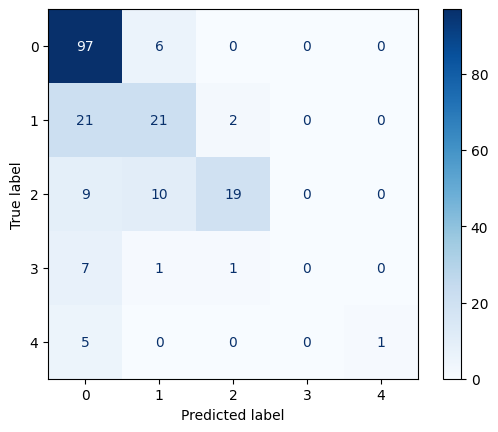

In [82]:
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(cmap='Blues')

In [54]:
# define function
def audio_to_mfccs(filename, sample_rate=44100, offset=0, duration=None):
    voice, sample_rate = librosa.load(filename, sr=sample_rate, offset=offset, duration=duration)

    n_fft = int(128/1000 * sample_rate)  # Convert 16 ms to samples
    hop_length = int(64/1000 * sample_rate)  # Convert 8 ms to samples
    mfcc_feature = librosa.feature.mfcc(y=voice, sr=sample_rate, n_mfcc=13, n_fft=n_fft, hop_length=hop_length)

    delta_mfcc_feature = librosa.feature.delta(mfcc_feature)
    mfccs = np.concatenate((mfcc_feature, delta_mfcc_feature))
    mfccs_features = np.transpose(mfccs)  # all frames

    return mfccs_features

In [55]:
# 在dataframe中加入要訓練的音檔路徑
source_df['wav_path'] = source_df['ID'].map("./data/training_data/{}.wav".format)
print("Disease category in training_df :", source_df['Disease category'].unique())
print("training_df col :\n", source_df.columns)
print("training_df shape :", source_df.shape)

Disease category in training_df : [1 2 3 5 4]
training_df col :
 Index(['ID', 'Sex', 'Age', 'Disease category', 'Narrow pitch range',
       'Decreased volume', 'Fatigue', 'Dryness', 'Lumping', 'heartburn',
       'Choking', 'Eye dryness', 'PND', 'Smoking', 'PPD', 'Drinking',
       'frequency', 'Diurnal pattern', 'Onset of dysphonia ', 'Noise at work',
       'Occupational vocal demand', 'Diabetes', 'Hypertension', 'CAD',
       'Head and Neck Cancer', 'Head injury', 'CVA',
       'Voice handicap index - 10', 'wav_path'],
      dtype='object')
training_df shape : (1000, 29)


In [56]:
id = source_df['ID'].tolist()
#print(training_id[0])
wav_length = []
for i in id:
  mfccs_feature = audio_to_mfccs(source_df[source_df['ID']==i]['wav_path'].values[0])
  #print(mfccs_feature.shape[0])
  wav_length.append(mfccs_feature.shape[0])

In [57]:
print(wav_length)

[32, 47, 32, 32, 47, 47, 32, 47, 47, 47, 47, 47, 32, 47, 16, 32, 16, 47, 32, 47, 32, 32, 47, 32, 32, 47, 24, 32, 32, 32, 32, 47, 47, 32, 47, 47, 32, 47, 47, 32, 47, 32, 47, 32, 32, 47, 47, 47, 32, 32, 47, 32, 47, 47, 32, 47, 47, 47, 32, 47, 32, 24, 47, 47, 47, 47, 47, 32, 47, 47, 47, 47, 47, 16, 47, 47, 47, 47, 47, 47, 47, 47, 16, 32, 47, 47, 32, 32, 47, 47, 24, 32, 32, 16, 47, 32, 47, 32, 47, 47, 47, 47, 47, 32, 32, 47, 47, 47, 16, 47, 47, 47, 16, 47, 32, 47, 32, 47, 32, 47, 47, 32, 47, 47, 16, 47, 47, 47, 32, 47, 32, 32, 47, 32, 47, 32, 47, 32, 47, 47, 32, 47, 47, 32, 24, 47, 47, 16, 47, 32, 47, 32, 32, 32, 32, 32, 47, 32, 47, 24, 47, 32, 32, 47, 47, 32, 47, 47, 32, 47, 32, 16, 47, 47, 32, 47, 32, 47, 47, 47, 47, 47, 32, 47, 32, 47, 47, 47, 47, 47, 16, 47, 47, 47, 47, 32, 47, 47, 32, 32, 47, 32, 47, 47, 32, 47, 47, 47, 47, 32, 47, 47, 32, 32, 32, 47, 47, 47, 47, 47, 32, 47, 47, 32, 47, 32, 32, 32, 32, 47, 47, 47, 32, 47, 47, 47, 47, 47, 47, 47, 32, 32, 47, 32, 47, 47, 32, 32, 47, 47,

In [58]:
col_name = source_df.columns.tolist()
col_name.insert(col_name.index('wav_path')+1,'wav_length')
new_df=source_df.reindex(columns=col_name)

In [59]:
print("new_df col :\n", new_df.columns)

new_df col :
 Index(['ID', 'Sex', 'Age', 'Disease category', 'Narrow pitch range',
       'Decreased volume', 'Fatigue', 'Dryness', 'Lumping', 'heartburn',
       'Choking', 'Eye dryness', 'PND', 'Smoking', 'PPD', 'Drinking',
       'frequency', 'Diurnal pattern', 'Onset of dysphonia ', 'Noise at work',
       'Occupational vocal demand', 'Diabetes', 'Hypertension', 'CAD',
       'Head and Neck Cancer', 'Head injury', 'CVA',
       'Voice handicap index - 10', 'wav_path', 'wav_length'],
      dtype='object')


In [60]:
for i in range(len(new_df['ID'])):
  new_df['wav_length'][i] = wav_length[i]

<ipython-input-60-b70e5dc39ae2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['wav_length'][i] = wav_length[i]


In [61]:
print(new_df)

          ID  Sex  Age  Disease category  Narrow pitch range  \
0    1202f15    2   39                 1                   1   
1    0600ve0    1   69                 2                   1   
2    1001o7l    2   59                 2                   1   
3    1201c1t    2   47                 1                   1   
4    0402jvt    1   87                 1                   0   
..       ...  ...  ...               ...                 ...   
995  0G00ftn    1   75                 3                   0   
996  1201pkr    1   40                 4                   0   
997  0202p64    2   68                 3                   0   
998  12021au    2   42                 2                   0   
999  04027it    1   72                 2                   1   

     Decreased volume  Fatigue  Dryness  Lumping  heartburn  ...  \
0                   1        1        1        1          0  ...   
1                   1        1        1        0          0  ...   
2                   1      

In [62]:
X = new_df.drop(['Disease category','ID','wav_path'],axis=1)
y = new_df['Disease category']

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [64]:
X_train = medical_data_proccessing(X_train)
X_test = medical_data_proccessing(X_test)

In [65]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(800, 27)
(200, 27)
(800,)
(200,)


In [66]:
rf2 = RandomForestClassifier()
rf2.fit(X_train, y_train)

RandomForestClassifier()

In [68]:
y_pred = rf2.predict(X_test)

In [69]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.645


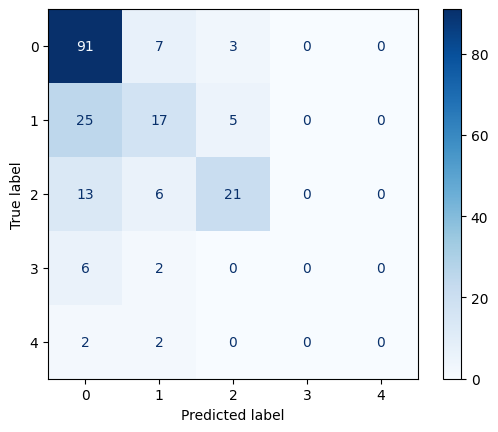

In [72]:
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(cmap='Blues')